# Spark Exploration

In [33]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

import warnings 
warnings.filterwarnings("ignore")

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [34]:
# Use the wrangle function provided by Zach to prepare and
# combine the 311 dataset.
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [41]:
# Display the shape of the spark dataframe
print(f'There are {df.count():,} observations and {len(df.columns)} features.')

There are 841,704 observations and 20 features.


# Exercise Questions

In [42]:
# Display a single observation to the collective features represent.
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



## 1. How many different cases are there, by department?

>To answer this question, we'll need to use: `groupby()` and `countDistinct()`. We want to find the number of different (meaning: DISTINCT) cases each department handles. This will give us information to consider when looking at open/close, late/not late case time differences.
```python
(
# We groupby the department column to set it as our index (meaning: Observations we're looking for)
df.groupby('department')
    
# We use the aggregate function to collect values by passing a function
.agg(
    # The function we pass is `countDistinct()`. It counts the number of distinct values
    # in a column. In our case 'service_request_type'.
    countDistinct('service_request_type')
    
    # Give the aggregation an alias for presentation.
    .alias('distinct_cases'))
    
# Sort by the department column for presentation.
.sort('department')
    
# Display the results without truncating strings longer than 20 characters.
.show(truncate=False)
)
```

In [43]:
# Answer with inline comments removed.
(
df.groupby('department')
.agg(countDistinct('service_request_type').alias('distinct_cases'))
.sort('department')
.show(truncate=False)
)

+------------------------+--------------+
|department              |distinct_cases|
+------------------------+--------------+
|Animal Care Services    |14            |
|City Council            |2             |
|Customer Service        |2             |
|DSD/Code Enforcement    |122           |
|Metro Health            |14            |
|Parks & Recreation      |44            |
|Solid Waste             |56            |
|Trans & Cap Improvements|81            |
+------------------------+--------------+



2. Does the percentage of cases that are late vary by department?
> To answer this question let's first establish what were looking for:<br>
__Percentage of cases that are late by department__<br>

This one was a bit challenging.

```python
(
# Group the dataframe by the department column to set it as the index
# ->The observation we're looking for: 'departments.
df.groupby('department')

# We pivot the 'case_late' column to create a new dataframe
# 'case_late' values: True if a case is late, False otherwise.
.pivot('case_late')

# Use the count function to total the number of late cases and on-time cases.
.count()
    
# Select the 'department' column for context from the pivoted dataframe.
.select('department',

        # Calculate the proportion of late cases per department.
        # Formula per department: total late cases / total cases.
        # Round for presentation
        round((col('true') / (col('true') + col('false'))), 3)
        
        # Alias the calculation for context and presentation
        .alias('pct_cases_late'))
    
# City council had 0 missing cases. Fill with 0.
.na.fill(0)
    
# Sort by department for presentation
.sort('department')
    
# display the results
.show()
)
```

In [122]:
# Answer with inline comments removed.
df_department_pct_late_cases = (

    df.groupby('department')
      .pivot('case_late')
    .count()
    .select('department',
            round((col('true')
                   / (col('true') + col('false')))
                  , 6)
            .alias('pct_cases_late'))
    
    .na.fill(0)
    .sort('department')
)

df_department_pct_late_cases.show(truncate=False)

+------------------------+--------------+
|department              |pct_cases_late|
+------------------------+--------------+
|Animal Care Services    |0.199085      |
|City Council            |0.0           |
|Customer Service        |0.705511      |
|DSD/Code Enforcement    |0.081634      |
|Metro Health            |0.160566      |
|Parks & Recreation      |0.190737      |
|Solid Waste             |0.117968      |
|Trans & Cap Improvements|0.056251      |
+------------------------+--------------+



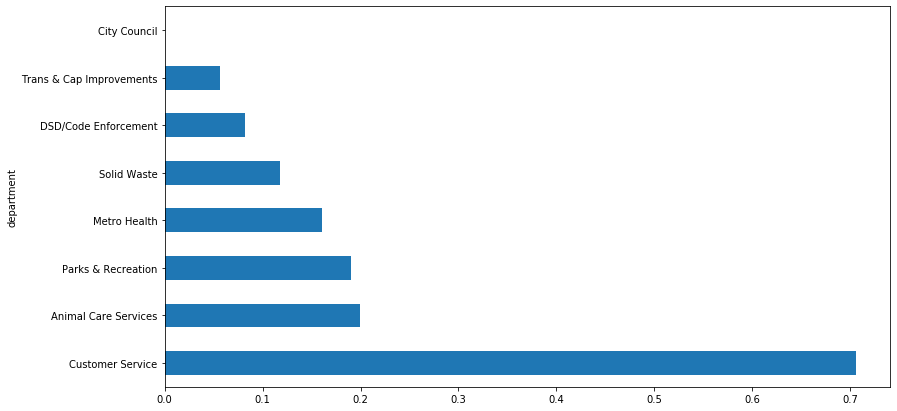

In [127]:
(
df_department_pct_late_cases
.toPandas()
.set_index('department')
['pct_cases_late'].sort_values(ascending=False)
.plot.barh(figsize=(13, 7))
);

3. On average, how late are the late cases by department?

4. What is the service type that is the most late? Just for Parks & Rec?

5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

6. Does whether or not its a weekend matter for when a case is opened/closed?

7. On average, how many cases are opened a day for the Customer Service department?

8. Does the number of service requests for the solid waste department vary by day of the week?